In [49]:
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage import transform
from PIL import Image
from skimage.color import rgb2gray

plt.rcParams["figure.figsize"] = (8,8)

# Benchmark - RRDN vs Polytion

## RRDN - State of the art Super Resulution

**Load and pre-process images**

In [2]:
def load_images_from_folder(folder):
    images = []
    for root, dirs, files in os.walk(folder, topdown=True):        
        for file in files:
            img = Image.open(os.path.join(root, file))
            images.append(np.asarray(img))
            img.close()
    return images

In [4]:
images=load_images_from_folder('input/test_images/004408_01_02')

In [5]:
#preprocess images
d=512
s = 4
dpi = 72
d_new = round(d/s)
num=len(images)
img_orig=np.zeros((num,d,d))
images_lr = []
filename = 'input/test_images/test_fig.png'
figsize = d_new / float(dpi), d_new / float(dpi)

for n in range(num):
    img_orig[n]=np.asarray(images[n])
    
    #normalization
    minval= np.min(img_orig[n])
    maxval= np.max(img_orig[n])
    img_orig[n]=(img_orig[n]-minval)/maxval
    
    #downscale images to low resolution,
    im = transform.resize(img_orig[n], (d_new, d_new), anti_aliasing=True)

    #Save image using matplotlib to convert to RGB png image format necessary for RDN
    fig = plt.figure(figsize=figsize)
    plt.imshow(im, cmap='gist_gray')

    #remove white spaces
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.savefig(filename)
    plt.close(fig)

    #load open the saved LR image
    im = Image.open(filename) 
    im = im.convert('RGB')
    im = np.asarray(im)
    images_lr.append(im)
       
images_lr = np.asarray(images_lr)
images_lr.shape

(59, 128, 128, 3)

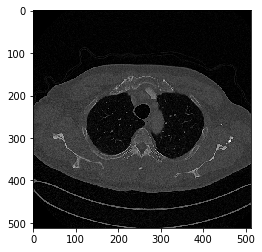

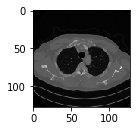

In [6]:
plt.imshow(img_orig[15],cmap='gist_gray')
plt.show()
plt.figure(figsize=figsize)
plt.imshow(images_lr[15],cmap='gist_gray')
plt.show()

### Predict image
Use pre-trained RRDN model

Implementation of the Residual in Residual Dense Network for image super-scaling.
The network is the one described in https://arxiv.org/abs/1809.00219 (Wang et al. 2018).

In [35]:
from ISR.models import RRDN
from PIL import Image
model = RRDN(weights='gans')

In [63]:
# PREDICT one sample
# im_sr = model.predict(np.array(fake))
# im_sr = np.array(im_sr)
# im_sr = rgb2gray(im_sr) #flatten to 1 chanell
# im_sr.shape

In [60]:
#PREDICT all samples
images_sr = []

for i in range(num):
    im_sr = model.predict(np.array(images_lr[i]))
    im_sr = np.array(im_sr)
    im_sr = rgb2gray(im_sr) #flatten to 1 chanell
    images_sr.append(im_sr)

images_sr = np.asarray(images_sr)
images_sr.shape

(59, 512, 512)

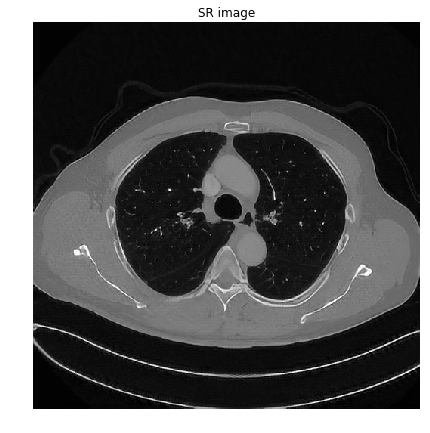

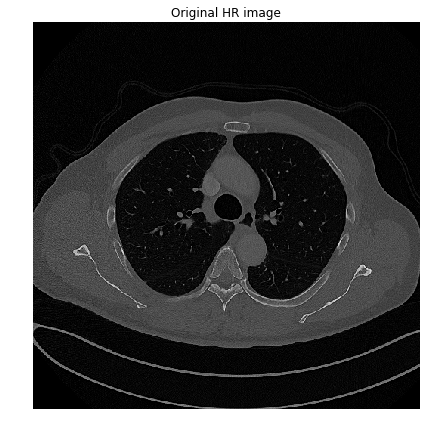

In [70]:
n = 50
fake = images_sr[n]
real = img_orig[n]
#fake_upscaled = transform.resize(fake,(d, d))

height, width = fake.shape
figsize = width / float(dpi), height / float(dpi)
plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(fake,cmap='gist_gray')
plt.title("SR image")
plt.show()


plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(real,cmap='gist_gray')
plt.title("Original HR image")
plt.show()

## Image Quality metrics

#### PSNR 
Typical values for the PSNR in lossy image and video compression are between 30 and 50 dB, higher the better
![oo](https://wikimedia.org/api/rest_v1/media/math/render/svg/fc22801ed1232ff1231c4156b589de5c32063a8a)

#### SSIM 
formula is based on three comparison measurements: luminance, contrast and structure.    
It is a decimal value between -1 and 1, and value 1 is only reachable in the case of two identical sets of data and therefore indicates perfect structural similarity. A value of 0 indicates no structural similarity. For an image, it is typically calculated using a sliding Gaussian window of size 11x11 or a block window of size 8×8.

In [55]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import mean_squared_error as mse

### RRDN

In [112]:
res = np.zeros((4,num))
for i in range(num):
    res[0,i] = ssim(images_sr[i], img_orig[i])
    res[1,i] = psnr(images_sr[i], img_orig[i])
    res[2,i] = nrmse(images_sr[i], img_orig[i])
    res[3,i] = mse(images_sr[i], img_orig[i])

In [119]:
metrics = ['ssim','psnr','nrmse','mse']
res_mean = res.mean(axis=1)

print("SSIM: %s"%res_mean[0])
print("psnr: %s"%res_mean[1])
print("nrmse: %s"%res_mean[2])
print("mse: %s"%res_mean[3])   

SSIM: 0.20876912256173008
psnr: 12.221250394679867
nrmse: 0.927797298025228
mse: 0.06174429061801817


In [110]:
x = np.asarray(range(0,num))

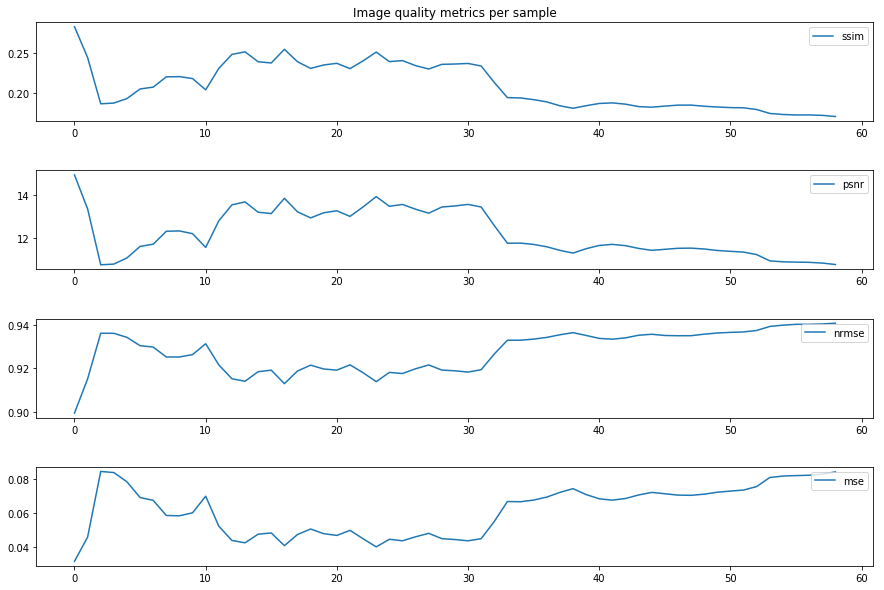

In [145]:
fig, ax = plt.subplots(4,1,figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
ax[0].set_title("Image quality metrics per sample")
ax[0].plot(x,res[0],label=metrics[0])
ax[0].legend(loc="upper right")
ax[1].plot(x,res[1],label=metrics[1])
ax[1].legend(loc="upper right")
ax[2].plot(x,res[2],label=metrics[2])
ax[2].legend(loc="upper right")
ax[3].plot(x,res[3],label=metrics[3])
ax[3].legend(loc="upper right")

plt.show()

### Polytion
//todo